# SLEEP DATA ANALYSIS

In [67]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from sklearn.preprocessing import LabelEncoder
sb.set() # set the default Seaborn style for graphics

## Importing the sleep data set

In [68]:
sleepData = pd.read_csv("sleepData.csv")

## Cleaning & Encoding columns in DataSet

In [69]:
# Replace 'Normal Weight' with 'Normal' in the 'BMI Category' column
sleepData["BMI Category"] = sleepData["BMI Category"].replace("Normal Weight", "Normal")
# Extract the value before '/' symbol
sleepData['Blood Pressure'] = sleepData['Blood Pressure'].str.split('/').str[0]


# initiate Label Encoder
label_encoder = LabelEncoder()
sleepData["BMI Category"] = label_encoder.fit_transform(sleepData["BMI Category"])
# Normal: 0, Normal Weight: 1, Obese: 2, Overweight: 3

# Replace NaN with 0 and map 'Sleep Apnea' and 'Insomnia' to 1
sleepData["Sleep Disorder"] = sleepData["Sleep Disorder"].fillna(0)
sleepData["Sleep Disorder"] = sleepData["Sleep Disorder"].replace(['Sleep Apnea', 'Insomnia'], 1)
# Convert column to integer type
sleepData["Sleep Disorder"] = sleepData["Sleep Disorder"].astype(int)

sleepData.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,2,126,77,4200,0
1,2,Male,28,Doctor,6.2,6,60,8,0,125,75,10000,0
2,3,Male,28,Doctor,6.2,6,60,8,0,125,75,10000,0
3,4,Male,28,Sales Representative,5.9,4,30,8,1,140,85,3000,1
4,5,Male,28,Sales Representative,5.9,4,30,8,1,140,85,3000,1


In [70]:
sleepDuration = pd.DataFrame(sleepData["Sleep Duration"])
sleepQuality = pd.DataFrame(sleepData["Quality of Sleep"])
physicalActivity = pd.DataFrame(sleepData["Physical Activity Level"])
stressLevel = pd.DataFrame(sleepData["Stress Level"])
bmiCategory = pd.DataFrame(sleepData["BMI Category"])
bloodPressure = pd.DataFrame(sleepData["Blood Pressure"])
heartRate = pd.DataFrame(sleepData["Heart Rate"])
dailySteps = pd.DataFrame(sleepData["Daily Steps"])
sleepDisorder = pd.DataFrame(sleepData["Sleep Disorder"])

## Split dataset into training and test sets

In [71]:
from sklearn.model_selection import train_test_split, cross_val_score

# Combine variables into a single DataFrame
X = pd.concat([sleepDuration, sleepQuality, physicalActivity, stressLevel, bmiCategory, 
               bloodPressure, heartRate, dailySteps], axis=1)
y = sleepDisorder.values.ravel()  # Flatten sleepDisorder into a 1D array

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Scale predictor variables

In [72]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use logistic Regression Model
## Base case model (most simple)

### We use recursive feature selection to select the most important features and then fit the logistic regression model with those features

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

def logisticRegression(X_train_scaled, X_test_scaled, y_train, noFeatures):
    # Initialize SelectKBest with f_classif (ANOVA F-value between label/feature)
    selector = SelectKBest(score_func=f_classif, k=noFeatures)

    # Fit SelectKBest to training data and transform it
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    # Get selected features indices
    selected_features_indices = selector.get_support(indices=True)

    # Get the names of selected features
    selected_features = X_train.columns[selected_features_indices]

    # Initialize logistic regression model
    log_reg_model = LogisticRegression()

    # Fit the logistic regression model to your training data with selected features
    log_reg_model.fit(X_train_selected, y_train)

    # Predict data
    y_pred_log = log_reg_model.predict(X_test_selected)

    return y_pred_log , list(selected_features)


In [74]:
y_pred_Top6, top6Features = logisticRegression(X_train_scaled, X_test_scaled, y_train, 6) 
y_pred_Top5, top5Features = logisticRegression(X_train_scaled, X_test_scaled, y_train, 5) 
y_pred_Top4, top4Features = logisticRegression(X_train_scaled, X_test_scaled, y_train, 4) 
y_pred_Top3, top3Features = logisticRegression(X_train_scaled, X_test_scaled, y_train, 3) 
y_pred_Top2, top2Features = logisticRegression(X_train_scaled, X_test_scaled, y_train, 2) 
y_pred_Top1, top1Features = logisticRegression(X_train_scaled, X_test_scaled, y_train, 1) 

### Ranking all features feature selection

In [75]:
rankedFeatures = []
topFeatures = [top1Features, top2Features, top3Features, top4Features, top5Features, top6Features]
for i in topFeatures:
    for j in i:
        if j not in rankedFeatures:
            rankedFeatures.append(j)
print("Ranking all Features: ")
for i in range(len(rankedFeatures)):
    print(f"{i+1}: {rankedFeatures[i]}")

Ranking all Features: 
1: BMI Category
2: Blood Pressure
3: Sleep Duration
4: Quality of Sleep
5: Heart Rate
6: Stress Level


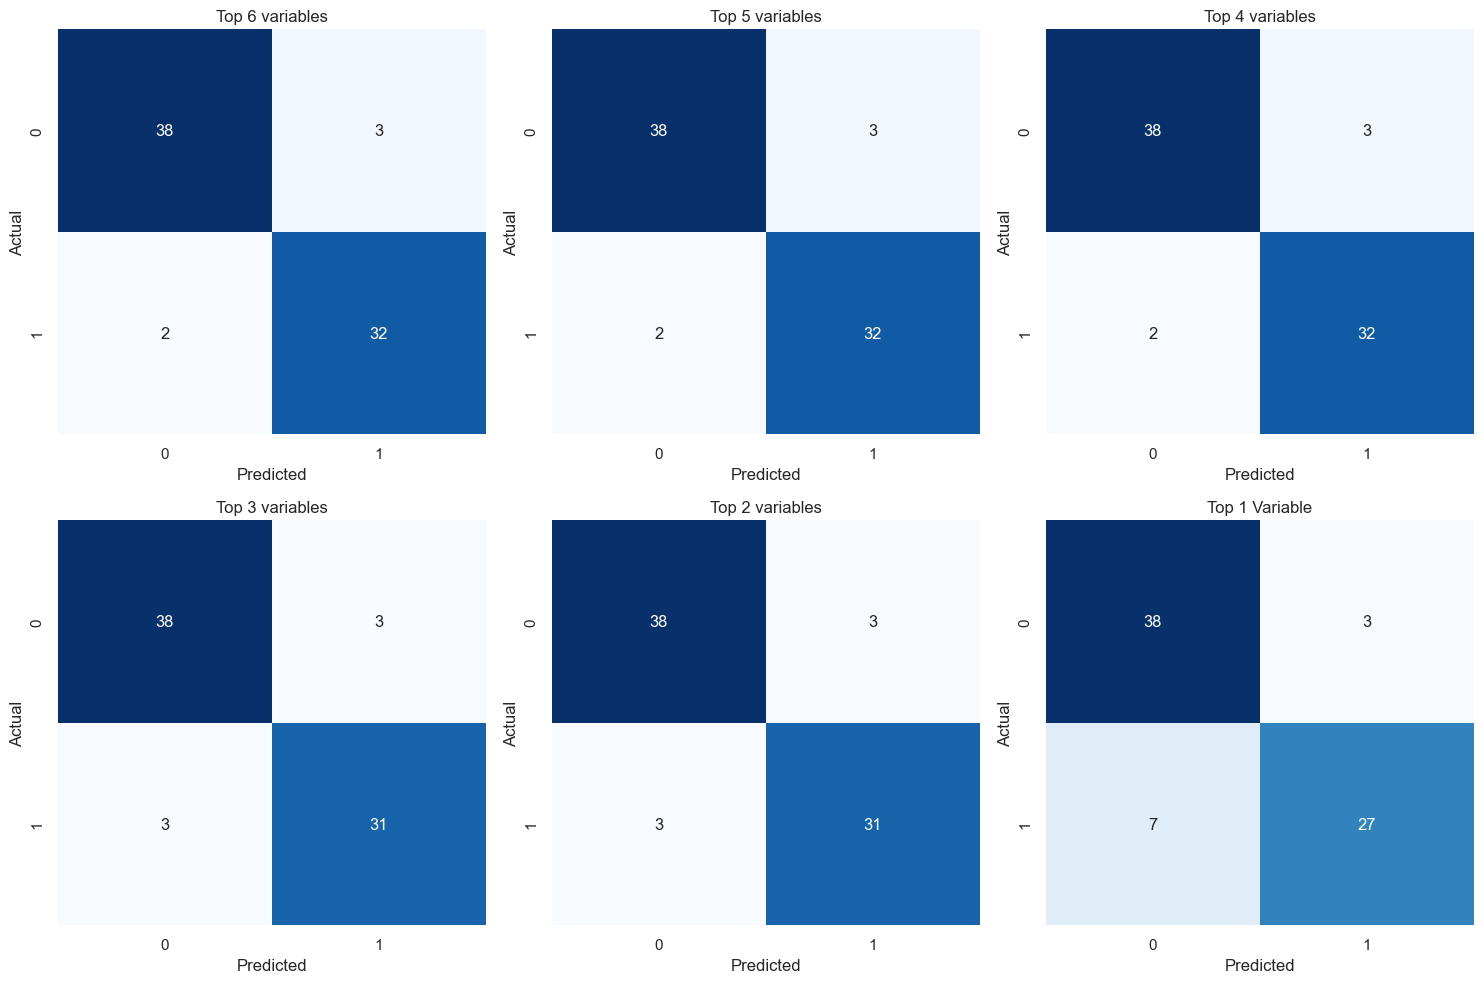

In [76]:
from sklearn.metrics import confusion_matrix

# Define the predictions and their titles
predictions = [y_pred_Top6, y_pred_Top5, y_pred_Top4, y_pred_Top3, y_pred_Top2, y_pred_Top1]
titles = ['Top 6 variables', 'Top 5 variables', 'Top 4 variables', 'Top 3 variables', 'Top 2 variables', 'Top 1 Variable']

# Define the number of columns
num_columns = 3

# Calculate the number of rows needed
num_rows = (len(predictions) + num_columns - 1) // num_columns

# Create subplots with specified number of rows and columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Flatten the axes if it's a 1D array
if num_rows == 1:
    axes = [axes]

# Calculate confusion matrix for each prediction
for i, (y_pred, title) in enumerate(zip(predictions, titles)):
    conf_matrix = confusion_matrix(y_test, y_pred)
    row = i // num_columns
    col = i % num_columns
    sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[row, col])
    axes[row, col].set_title(title, )
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('Actual')

# Hide empty subplots
for i in range(len(predictions), num_rows * num_columns):
    row = i // num_columns
    col = i % num_columns
    fig.delaxes(axes[row, col])

# Adjust layout
plt.tight_layout()
plt.show()

# Using Random Forest Model
## Checking which features are more important
Feature Importance: If you're using tree-based models like Random Forest, you can use the built-in feature importance attribute to identify the most important features. Features with higher feature importance scores are considered more relevant for predicting the target variable.

                   Feature  Importance
4             BMI Category    0.333001
5           Blood Pressure    0.253339
0           Sleep Duration    0.157497
6               Heart Rate    0.060304
1         Quality of Sleep    0.057170
3             Stress Level    0.050046
7              Daily Steps    0.046062
2  Physical Activity Level    0.042582


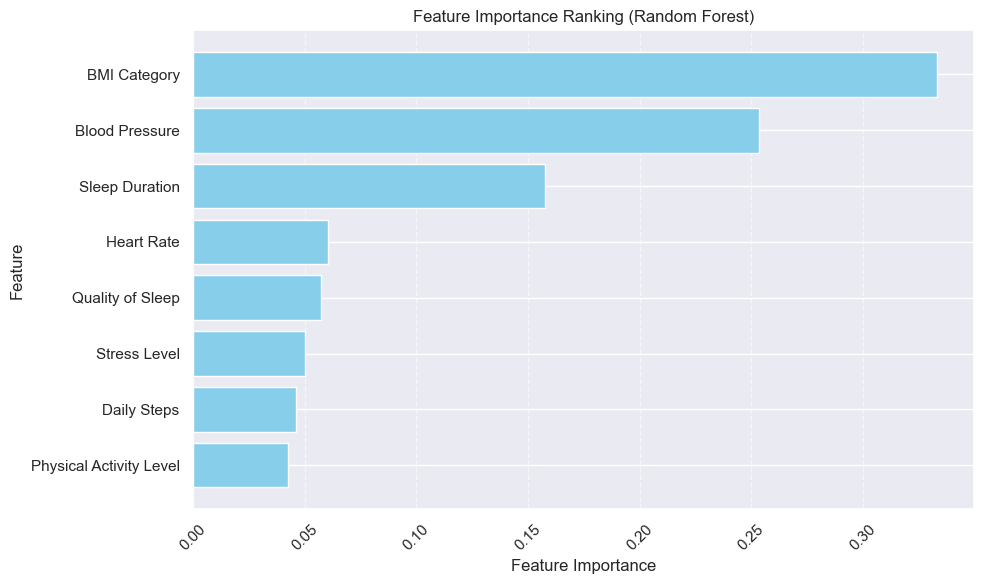

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize model
random_forest = RandomForestClassifier()

# Train the model
random_forest.fit(X_train_scaled, y_train)

# Get feature importances
feature_importances = random_forest.feature_importances_

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort features by importance (descending order)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# Get feature names and importances from the DataFrame 
features = feature_importance_df['Feature'].to_numpy()
importances = feature_importance_df['Importance'].to_numpy()


# Create a bar chart with this data
plt.figure(figsize=(10, 6))  # Adjust the figure size as desired
plt.barh(features, importances, color='skyblue')  # Bar plot with horizontal bars
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Ranking (Random Forest)')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important feature at the top

# Display grid lines and labels
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

### From analysing the feature importance, it can be shown that Blood Pressure, BMI Category and Sleep Duration are the variables that affect the likelihood of having sleeping disorder the most.

## Use all Features for this Model

In [78]:
# Evaluate the model that used all features using cross-validation
random_forest_scores = cross_val_score(random_forest, X_train_scaled, y_train, cv=5)
print("------------------------------------------- Using all features -------------------------------------------")
# Check model performance
print("Random Forest Cross-Validation Scores:", random_forest_scores)

# Make predictions on the testing data
y_pred = random_forest.predict(X_test_scaled)

# Evaluate the models on the test data
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\nUsing all features")
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

------------------------------------------- Using all features -------------------------------------------
Random Forest Cross-Validation Scores: [0.91666667 0.86666667 0.98333333 0.94915254 0.94915254]

Using all features
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96        41
           1       0.97      0.94      0.96        34

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75



In [79]:
# Function for random tree model

def random_forest_train_evaluate(X_train_scaled, X_test_scaled, y_train, y_test):
    # Initialize model
    random_forest = RandomForestClassifier()

    # Train the model
    random_forest.fit(X_train_scaled, y_train)

    # Evaluate the model that used all features using cross-validation
    random_forest_scores = cross_val_score(random_forest, X_train_scaled, y_train, cv=5)

    # Check model performance
    print("Random Forest Cross-Validation Scores:", random_forest_scores)

    # Make predictions on the testing data
    y_pred = random_forest.predict(X_test_scaled)

    # Evaluate the models on the test data
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)

    return y_pred


## Using Sleep duration, physical health and quality of sleep to predict SleepDisorder


In [80]:
# Filter X_train and X_test 
X_train_selectedBoomShakalaka = X_train[["Sleep Duration","Physical Activity Level","Quality of Sleep"]]
X_test_selectedBoomShakalaka = X_test[["Sleep Duration","Physical Activity Level","Quality of Sleep"]]

# # Scale the data
X_train_selectedBoomShakalaka_scaled = scaler.fit_transform(X_train_selectedBoomShakalaka)
X_test_selectedBoomShakalaka_scaled = scaler.transform(X_test_selectedBoomShakalaka)

print("--------------------------- Using Sleep Duration, Physical Activity, Quality Of Sleep ---------------------------")

# Put data into function
random_forest_train_evaluate(X_train_selectedBoomShakalaka_scaled, X_test_selectedBoomShakalaka_scaled, y_train, y_test)

--------------------------- Using Sleep Duration, Physical Activity, Quality Of Sleep ---------------------------
Random Forest Cross-Validation Scores: [0.95       0.86666667 0.96666667 0.91525424 0.93220339]
Accuracy: 0.9333333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94        41
           1       0.97      0.88      0.92        34

    accuracy                           0.93        75
   macro avg       0.94      0.93      0.93        75
weighted avg       0.94      0.93      0.93        75



array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1])

## Use top 2 most important Features for this model

In [81]:
# Select the top 2 features
top_2_features = feature_importance_df.head(2)['Feature'].tolist()
# Filter X_train and X_test to include only the top N features
X_train_selected2 = X_train[top_2_features]
X_test_selected2 = X_test[top_2_features]

# # Scale the data
X_train_selected2_scaled = scaler.fit_transform(X_train_selected2)
X_test_selected2_scaled = scaler.transform(X_test_selected2)

print("--------------------------------------- Using Top 2 most important features ---------------------------------------")

# Put data into function
random_forest_train_evaluate(X_train_selected2_scaled, X_test_selected2_scaled, y_train, y_test)

--------------------------------------- Using Top 2 most important features ---------------------------------------
Random Forest Cross-Validation Scores: [0.91666667 0.85       0.98333333 0.94915254 0.94915254]
Accuracy: 0.9466666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95        41
           1       0.97      0.91      0.94        34

    accuracy                           0.95        75
   macro avg       0.95      0.94      0.95        75
weighted avg       0.95      0.95      0.95        75



array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1])

## Use top 3 most important features for this Model

In [82]:
# Select the top 3 features
top_3_features = feature_importance_df.head(3)['Feature'].tolist()

# Filter X_train and X_test to include only the top N features
X_train_selected3 = X_train[top_3_features]
X_test_selected3 = X_test[top_3_features]

# # Scale the data
X_train_selected3_scaled = scaler.fit_transform(X_train_selected3)
X_test_selected3_scaled = scaler.transform(X_test_selected3)

print("--------------------------------------- Using Top 3 most important features ---------------------------------------")

# Put data into function
y_pred_selected3 = random_forest_train_evaluate(X_train_selected3_scaled, X_test_selected3_scaled, y_train, y_test)

--------------------------------------- Using Top 3 most important features ---------------------------------------
Random Forest Cross-Validation Scores: [0.91666667 0.85       0.98333333 0.94915254 0.94915254]
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96        41
           1       0.97      0.94      0.96        34

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75



# We observe from the accuracy and classification report that the model using the top 3 best feature has better accuracy and scores than the model using the top 2 features. The model using the top 3 features also has the same accuracy value and scores as the model using all features, hence this model is the most optimal.

## Demonstrate the model's performance by assessing its ROC AUC (Receiver Operating Characteristic Area Under the Curve).

[0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 0
 0 0 0 0 1 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1
 1]
[0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 0
 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1
 1]


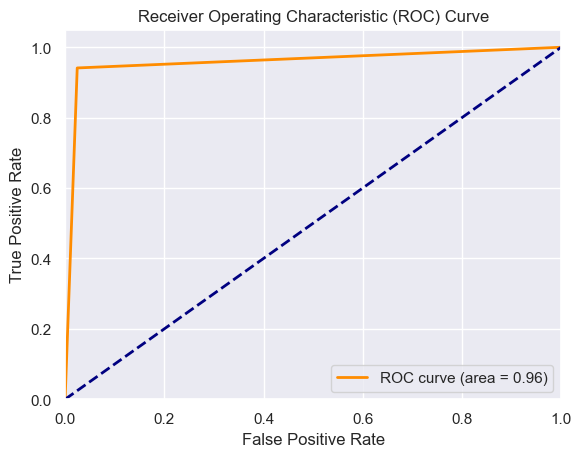

In [83]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_selected3)

# Compute Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## more right angle the top, better the model

# Gradient Boosting

BMI Category: 0.8014806620046161
Blood Pressure: 0.12196929306692914
Sleep Duration: 0.023632156447212747
Quality of Sleep: 0.020715640936678215
Heart Rate: 0.016833690687332915
Daily Steps: 0.014685109788435518
Physical Activity Level: 0.0004981843790133457
Stress Level: 0.0001852626897820893


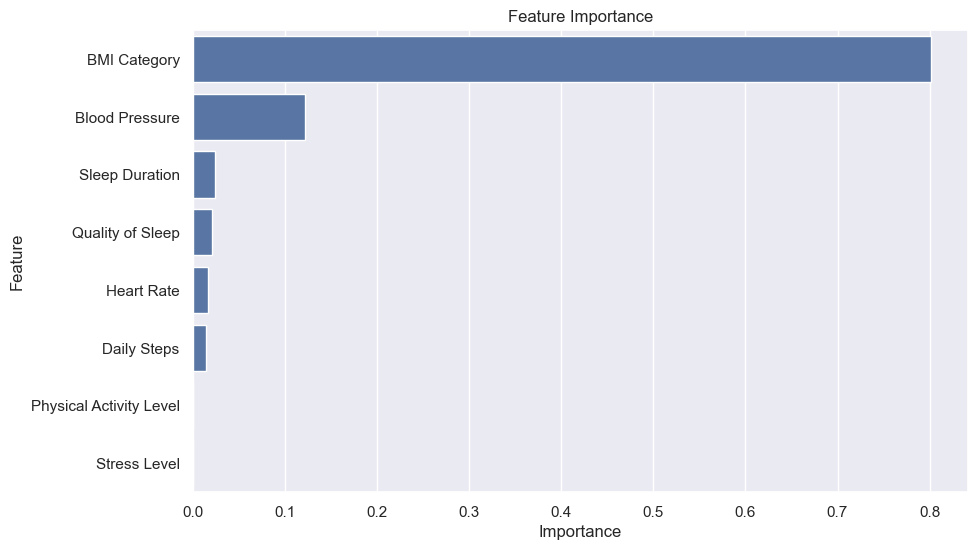

In [84]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Initialize Gradient Boosting Classifier
gb_model = GradientBoostingClassifier()

# Fit the model to your training data
gb_model.fit(X_train_scaled, y_train)

# Get feature importances
feature_importances = gb_model.feature_importances_

# Sort feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]

# Print feature names and their importances
for idx in sorted_indices:
    print(f"{X_train.columns[idx]}: {feature_importances[idx]}")

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort feature importances in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sb.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

## From gradient boosting, the most important feature by far is BMI Catergory

In [85]:
def gradientBoosting(X_train_scaled, X_test_scaled, y_train, y_test):
    # Assuming X_train, X_test, y_train, y_test are your train-test split data
    # Initialize Gradient Boosting Classifier
    gb_model = GradientBoostingClassifier()
    
    # Fit the model to your training data
    gb_model.fit(X_train_scaled, y_train)
    
    # Make predictions on the test data
    y_pred = gb_model.predict(X_test_scaled)
    
    # Evaluate the model's performance
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification report: ", report)

In [86]:
# Select the top 2 features
top_2_features = feature_importance_df.head(2)['Feature'].tolist()
# Select the top 3 features
top_3_features = feature_importance_df.head(3)['Feature'].tolist()

# Filter X_train and X_test to include only the top 2 features
X_train_selected2 = X_train[top_2_features]
X_test_selected2 = X_test[top_2_features]

# Filter X_train and X_test to include only the top 3 features
X_train_selected3 = X_train[top_3_features]
X_test_selected3 = X_test[top_3_features]

print("Gradient Boosting accuracy using top 2 features")
gradientBoosting(X_train_selected2, X_test_selected2, y_train, y_test)
print("\nGradient Boosting accuracy using top 3 features")
gradientBoosting(X_train_selected3, X_test_selected3, y_train, y_test)

Gradient Boosting accuracy using top 2 features
Accuracy: 0.9466666666666667
Classification report:                precision    recall  f1-score   support

           0       0.93      0.98      0.95        41
           1       0.97      0.91      0.94        34

    accuracy                           0.95        75
   macro avg       0.95      0.94      0.95        75
weighted avg       0.95      0.95      0.95        75


Gradient Boosting accuracy using top 3 features
Accuracy: 0.96
Classification report:                precision    recall  f1-score   support

           0       0.95      0.98      0.96        41
           1       0.97      0.94      0.96        34

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75



# Checking variables that affect stress level

## Use linear regression and compare stress level to selected variables

## Split the data into test and training sets

In [87]:
# Combine variables into a single DataFrame
X = pd.concat([sleepDuration, sleepQuality, physicalActivity, sleepDisorder, bmiCategory, 
               bloodPressure, heartRate, dailySteps], axis=1)

y = stressLevel.values.ravel()  # Flatten sleepDisorder into a 1D array

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scale training and test sets

In [88]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic Regression on top features to predict Stress Level

In [89]:
y_pred_Top6, top6Features = logisticRegression(X_train_scaled, X_test_scaled, y_train, 6) 
y_pred_Top5, top5Features = logisticRegression(X_train_scaled, X_test_scaled, y_train, 5) 
y_pred_Top4, top4Features = logisticRegression(X_train_scaled, X_test_scaled, y_train, 4) 
y_pred_Top3, top3Features = logisticRegression(X_train_scaled, X_test_scaled, y_train, 3) 
y_pred_Top2, top2Features = logisticRegression(X_train_scaled, X_test_scaled, y_train, 2) 
y_pred_Top1, top1Features = logisticRegression(X_train_scaled, X_test_scaled, y_train, 1) 

In [90]:
### Ranking all features feature selection

In [91]:
rankedFeatures = []
topFeatures = [top1Features, top2Features, top3Features, top4Features, top5Features, top6Features]
for i in topFeatures:
    for j in i:
        if j not in rankedFeatures:
            rankedFeatures.append(j)
print("Ranking all Features: ")
for i in range(len(rankedFeatures)):
    print(f"{i+1}: {rankedFeatures[i]}")

Ranking all Features: 
1: Quality of Sleep
2: Sleep Duration
3: Heart Rate
4: Daily Steps
5: Sleep Disorder
6: BMI Category


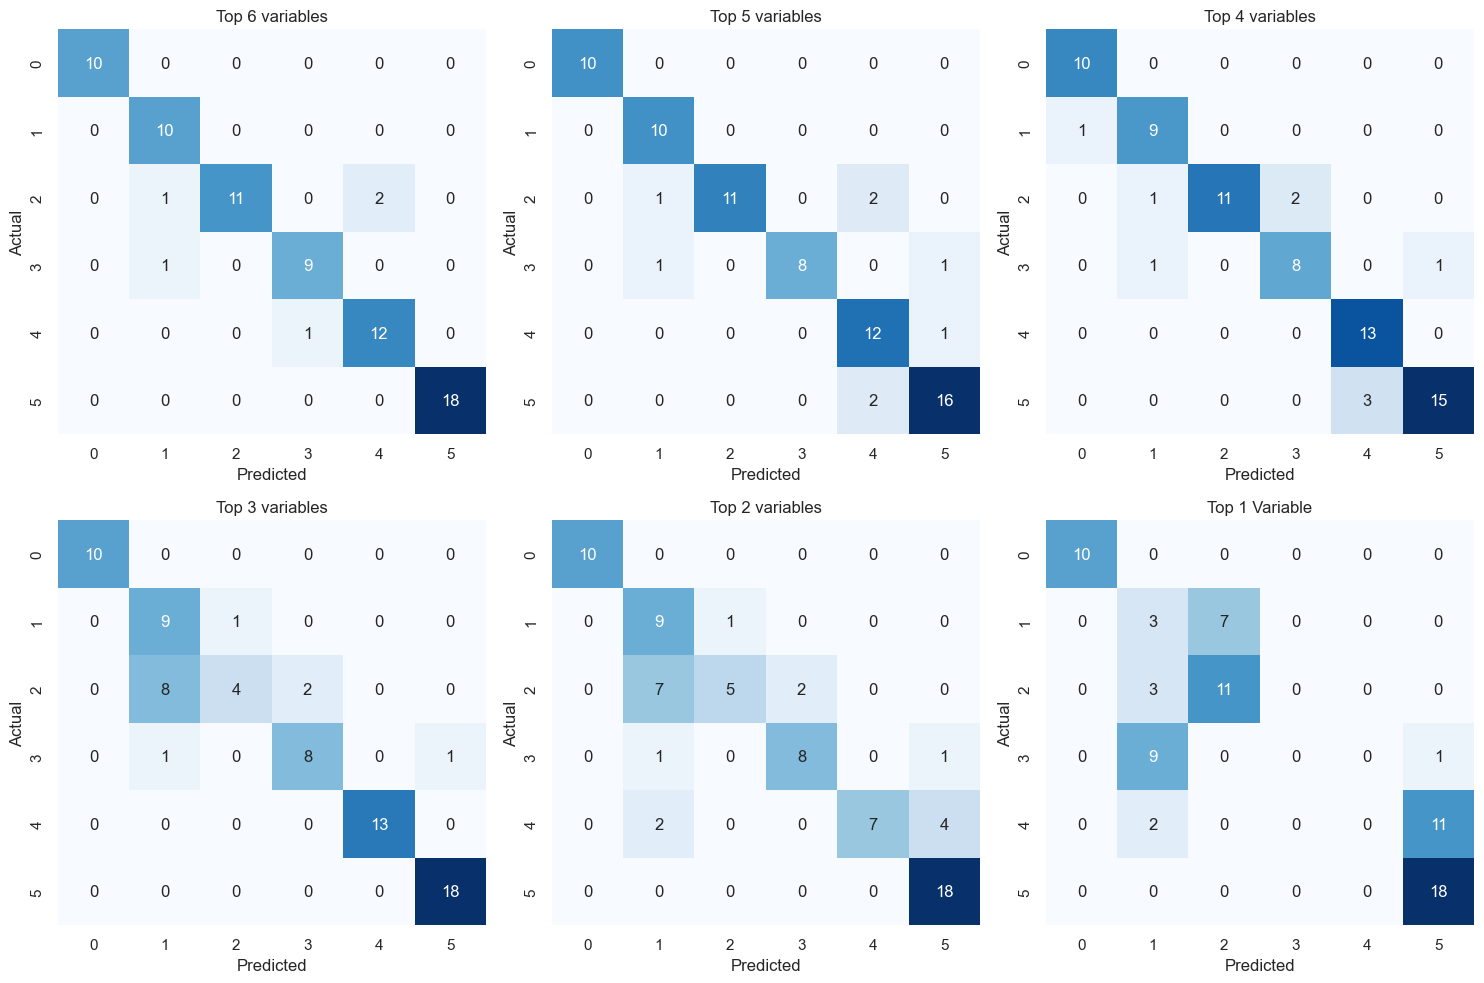

In [92]:
# Define the predictions and their titles
predictions = [y_pred_Top6, y_pred_Top5, y_pred_Top4, y_pred_Top3, y_pred_Top2, y_pred_Top1]
titles = ['Top 6 variables', 'Top 5 variables', 'Top 4 variables', 'Top 3 variables', 'Top 2 variables', 'Top 1 Variable']

# Define the number of columns
num_columns = 3

# Calculate the number of rows needed
num_rows = (len(predictions) + num_columns - 1) // num_columns

# Create subplots with specified number of rows and columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Flatten the axes if it's a 1D array
if num_rows == 1:
    axes = [axes]

# Calculate confusion matrix for each prediction
for i, (y_pred, title) in enumerate(zip(predictions, titles)):
    conf_matrix = confusion_matrix(y_test, y_pred)
    row = i // num_columns
    col = i % num_columns
    sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[row, col])
    axes[row, col].set_title(title, )
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('Actual')

# Hide empty subplots
for i in range(len(predictions), num_rows * num_columns):
    row = i // num_columns
    col = i % num_columns
    fig.delaxes(axes[row, col])

# Adjust layout
plt.tight_layout()
plt.show()

# Using Random Forest Model

## Checking Features Importance

                   Feature  Importance
0           Sleep Duration    0.219718
1         Quality of Sleep    0.186228
5           Blood Pressure    0.142608
6               Heart Rate    0.142585
7              Daily Steps    0.135984
2  Physical Activity Level    0.133791
4             BMI Category    0.020318
3           Sleep Disorder    0.018769


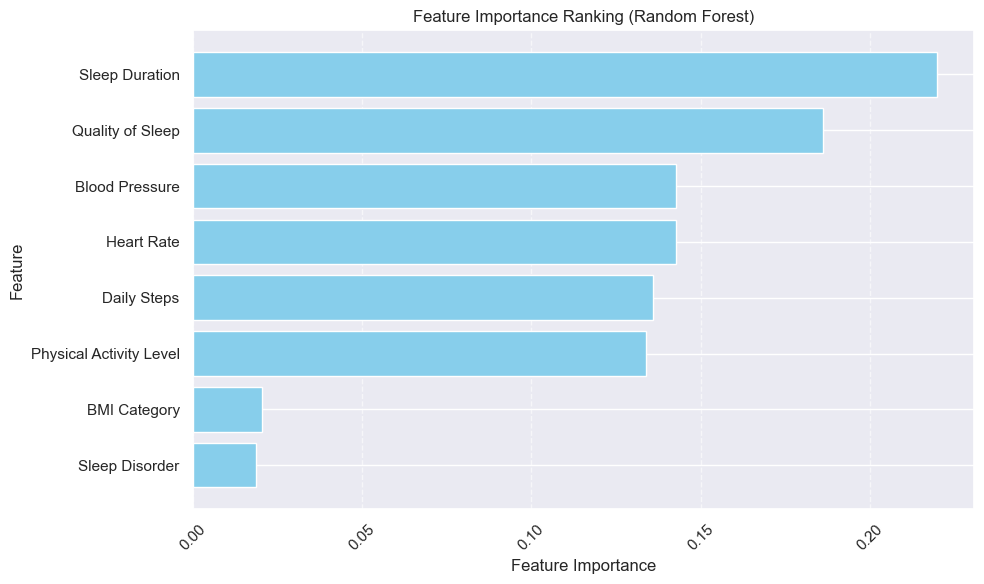

In [93]:
# Initialize model
random_forest = RandomForestClassifier()

# Train the model
random_forest.fit(X_train_scaled, y_train)

# Get feature importances
feature_importances = random_forest.feature_importances_

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort features by importance (descending order)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# Get feature names and importances from the DataFrame 
features = feature_importance_df['Feature'].to_numpy()
importances = feature_importance_df['Importance'].to_numpy()


# Create a bar chart with this data
plt.figure(figsize=(10, 6))  # Adjust the figure size as desired
plt.barh(features, importances, color='skyblue')  # Bar plot with horizontal bars
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Ranking (Random Forest)')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important feature at the top

# Display grid lines and labels
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

## Using all Features for this Model

In [94]:
# Evaluate the model that used all features using cross-validation
random_forest_scores = cross_val_score(random_forest, X_train_scaled, y_train, cv=5)
print("------------------------------------------- Using all features -------------------------------------------")
# Check model performance
print("Random Forest Cross-Validation Scores:", random_forest_scores)

# Make predictions on the testing data
y_pred = random_forest.predict(X_test_scaled)

# Evaluate the models on the test data
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\nUsing all features")
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

------------------------------------------- Using all features -------------------------------------------
Random Forest Cross-Validation Scores: [0.95       0.91666667 0.98333333 0.94915254 0.98305085]

Using all features
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00        18

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75



## Using Sleep duration, physical health and quality of sleep to predict Stress Level


In [95]:
# Filter X_train and X_test 
X_train_selectedBoomShakalaka = X_train[["Sleep Duration","Physical Activity Level","Quality of Sleep"]]
X_test_selectedBoomShakalaka = X_test[["Sleep Duration","Physical Activity Level","Quality of Sleep"]]

# # Scale the data
X_train_selectedBoomShakalaka_scaled = scaler.fit_transform(X_train_selectedBoomShakalaka)
X_test_selectedBoomShakalaka_scaled = scaler.transform(X_test_selectedBoomShakalaka)

print("--------------------------- Using Sleep Duration, Physical Activity, Quality Of Sleep ---------------------------")

# Put data into function
random_forest_train_evaluate(X_train_selectedBoomShakalaka_scaled, X_test_selectedBoomShakalaka_scaled, y_train, y_test)

--------------------------- Using Sleep Duration, Physical Activity, Quality Of Sleep ---------------------------
Random Forest Cross-Validation Scores: [0.88333333 0.9        0.88333333 0.86440678 0.84745763]
Accuracy: 0.9066666666666666
Classification Report:
               precision    recall  f1-score   support

           3       1.00      1.00      1.00        10
           4       0.60      0.90      0.72        10
           5       0.91      0.71      0.80        14
           6       1.00      1.00      1.00        10
           7       1.00      0.85      0.92        13
           8       1.00      1.00      1.00        18

    accuracy                           0.91        75
   macro avg       0.92      0.91      0.91        75
weighted avg       0.93      0.91      0.91        75



array([3, 8, 8, 3, 8, 7, 8, 4, 8, 5, 7, 6, 4, 8, 4, 8, 6, 7, 3, 4, 6, 5,
       8, 4, 4, 4, 7, 7, 7, 3, 6, 4, 6, 3, 8, 4, 8, 6, 4, 5, 7, 8, 7, 7,
       5, 4, 5, 6, 8, 6, 3, 5, 8, 5, 6, 3, 5, 8, 3, 8, 5, 4, 8, 6, 4, 8,
       7, 3, 5, 5, 4, 7, 4, 8, 3])

## Use top 2 most important Features for this model

In [96]:
# Select the top 2 features
top_2_features = feature_importance_df.head(2)['Feature'].tolist()
# Filter X_train and X_test to include only the top N features
X_train_selected2 = X_train[top_2_features]
X_test_selected2 = X_test[top_2_features]

# # Scale the data
X_train_selected2_scaled = scaler.fit_transform(X_train_selected2)
X_test_selected2_scaled = scaler.transform(X_test_selected2)

print("--------------------------------------- Using Top 2 most important features ---------------------------------------")

# Put data into function
random_forest_train_evaluate(X_train_selected2_scaled, X_test_selected2_scaled, y_train, y_test)

--------------------------------------- Using Top 2 most important features ---------------------------------------
Random Forest Cross-Validation Scores: [0.85       0.88333333 0.86666667 0.84745763 0.83050847]
Accuracy: 0.8533333333333334
Classification Report:
               precision    recall  f1-score   support

           3       1.00      1.00      1.00        10
           4       0.53      0.80      0.64        10
           5       0.82      0.64      0.72        14
           6       1.00      0.80      0.89        10
           7       0.92      0.85      0.88        13
           8       0.95      1.00      0.97        18

    accuracy                           0.85        75
   macro avg       0.87      0.85      0.85        75
weighted avg       0.88      0.85      0.86        75



array([3, 8, 8, 3, 8, 7, 8, 4, 8, 5, 7, 6, 4, 8, 4, 8, 8, 7, 3, 4, 6, 5,
       8, 4, 4, 4, 7, 7, 7, 3, 6, 5, 6, 3, 8, 4, 8, 6, 4, 5, 7, 8, 7, 7,
       5, 4, 5, 6, 8, 6, 3, 5, 8, 5, 7, 3, 5, 8, 3, 8, 5, 4, 8, 6, 4, 8,
       7, 3, 5, 4, 4, 7, 4, 8, 3])

## Using top 3 most important Features for this Model

In [97]:
# Select the top 3 features
top_3_features = feature_importance_df.head(3)['Feature'].tolist()

# Filter X_train and X_test to include only the top N features
X_train_selected3 = X_train[top_3_features]
X_test_selected3 = X_test[top_3_features]

# # Scale the data
X_train_selected3_scaled = scaler.fit_transform(X_train_selected3)
X_test_selected3_scaled = scaler.transform(X_test_selected3)

print("--------------------------------------- Using Top 3 most important features ---------------------------------------")

# Put data into function
y_pred_selected3 = random_forest_train_evaluate(X_train_selected3_scaled, X_test_selected3_scaled, y_train, y_test)

--------------------------------------- Using Top 3 most important features ---------------------------------------
Random Forest Cross-Validation Scores: [0.93333333 0.9        0.93333333 0.94915254 0.93220339]
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00        18

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75



## Demonstrate the model's performance by assessing its ROC AUC (Receiver Operating Characteristic Area Under the Curve).

In [98]:
# Compute ROC curve
print(y_test)
print(y_pred_selected3)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_selected3)

# Compute Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## more right angle the top, better the model

[3 8 8 3 8 7 8 4 8 5 7 6 5 8 5 8 6 7 3 4 6 5 8 4 4 5 7 7 7 3 6 4 6 3 8 4 8
 6 5 5 7 8 7 7 5 4 4 6 8 6 3 5 8 5 6 3 5 8 3 8 5 7 8 6 4 8 7 3 5 5 4 7 7 8
 3]
[3 8 8 3 8 7 8 4 8 5 7 6 5 8 5 8 6 7 3 4 6 5 8 4 4 5 7 7 7 3 6 4 6 3 8 4 8
 6 5 5 7 8 7 7 5 4 4 6 8 6 3 5 8 5 6 3 5 8 3 8 5 7 8 6 4 8 7 3 5 5 4 7 7 8
 3]


ValueError: multiclass format is not supported

# Gradient Boosting

In [ ]:
# Initialize Gradient Boosting Classifier
gb_model = GradientBoostingClassifier()

# Fit the model to your training data
gb_model.fit(X_train_scaled, y_train)

# Get feature importances
feature_importances = gb_model.feature_importances_

# Sort feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]

# Print feature names and their importances
for idx in sorted_indices:
    print(f"{X_train.columns[idx]}: {feature_importances[idx]}")

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort feature importances in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sb.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

### From Gradient Boosting

In [ ]:
def gradientBoosting(X_train_scaled, X_test_scaled, y_train, y_test):
    # Assuming X_train, X_test, y_train, y_test are your train-test split data
    # Initialize Gradient Boosting Classifier
    gb_model = GradientBoostingClassifier()
    
    # Fit the model to your training data
    gb_model.fit(X_train_scaled, y_train)
    
    # Make predictions on the test data
    y_pred = gb_model.predict(X_test_scaled)
    
    # Evaluate the model's performance
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification report: ", report)

In [ ]:
# Select the top 2 features
top_2_features = feature_importance_df.head(2)['Feature'].tolist()
# Select the top 3 features
top_3_features = feature_importance_df.head(3)['Feature'].tolist()

# Filter X_train and X_test to include only the top 2 features
X_train_selected2 = X_train[top_2_features]
X_test_selected2 = X_test[top_2_features]

# Filter X_train and X_test to include only the top 3 features
X_train_selected3 = X_train[top_3_features]
X_test_selected3 = X_test[top_3_features]

print("Gradient Boosting accuracy using top 2 features")
gradientBoosting(X_train_selected2, X_test_selected2, y_train, y_test)
print("\nGradient Boosting accuracy using top 3 features")
gradientBoosting(X_train_selected3, X_test_selected3, y_train, y_test)

### Function for linear regression returning predictions

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def LinearRegress(X_train, X_test, y_train): 
    # Fit the linear regression model on the training data
    linear_reg_model = LinearRegression()
    linear_reg_model.fit(X_train, y_train)
    
    # Make predictions on the training and testing data
    y_train_pred = linear_reg_model.predict(X_train)
    y_test_pred = linear_reg_model.predict(X_test)
    return [y_train_pred, y_test_pred]

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Assuming X_train_scaled, X_test_scaled, y_train, y_test are already defined

# Initialize the list of independent variables (IVs)
IVs = ['Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Sleep Disorder', 
       'BMI Category', 'Blood Pressure', 'Heart Rate', 'Daily Steps']

def return_mean_y(y_test, X_test_iv_scaled):
    unique_X_test = np.unique(X_test_iv_scaled)
    mean_y_test = []
    for val in unique_X_test:
        indices = np.where(X_test_iv_scaled == val)[0]
        mean_pred = np.mean(y_test[indices])
        mean_y_test.append(mean_pred)
    return unique_X_test, np.array(mean_y_test)



# Initialize lists to store RMSE values for each IV
rmse_test = []

# Initialize lists to store R^2 values for each model
r_square_values = []

# Initialize dictionary to store predictions for each IV
y_test_dict = {}

# Calculate number of rows needed
num_IVs = len(IVs)
num_cols = 2  # Maximum of 2 graphs per row
num_rows = (num_IVs + num_cols - 1) // num_cols

# Loop through each independent variable
for i, iv in enumerate(IVs):
    # Select the current IV from the DataFrame
    X_train_iv = X_train[[iv]]
    X_test_iv = X_test[[iv]]
    
    # Scale the train and test sets
    scaler = StandardScaler()
    X_train_iv_scaled = scaler.fit_transform(X_train_iv)
    X_test_iv_scaled = scaler.transform(X_test_iv)
    
    # Initialize and fit the linear regression model
    results = LinearRegress(X_train_iv_scaled, X_test_iv_scaled, y_train)
    
    # Make predictions on the testing data
    y_test_pred = results[1]
    
    # Calculate mean predicted value for each unique X_test value
    unique_X_test, mean_y_test = return_mean_y(y_test, X_test_iv_scaled)

    # Store mean predicted values for current IV
    y_test_dict[iv] = mean_y_test
    
    # Calculate RMSE for testing set
    rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

    # Calculate R^2 value
    r_squared = r2_score(y_test, y_test_pred)
    r_square_values.append(r_squared)
    
    # Create subplot
    if i % num_cols == 0:
        fig, axs = plt.subplots(1, num_cols, figsize=(12, 5))
    
    # Plot actual values
    axs[i % num_cols].plot(unique_X_test, mean_y_test, label='Actual', color='green')
    
    # Plot mean predicted values
    axs[i % num_cols].plot(X_test_iv_scaled, y_test_pred, label=f'Predicted ({iv})', color='blue')

    axs[i % num_cols].set_xlabel(f'{iv} (scaled)')
    axs[i % num_cols].set_ylabel('Stress Level')
    axs[i % num_cols].set_title(f'Actual vs Predicted for Stress Level (DV) using {iv} (IV)')
    axs[i % num_cols].legend()
    axs[i % num_cols].grid(True)
    
    # Show plot if it's the last subplot or the last IV
    if (i % num_cols == num_cols - 1) or (i == num_IVs - 1):
        plt.tight_layout()
        plt.show()

In [ ]:
# Display RMSE, R-squared, and Adjusted R-squared
for i, iv in enumerate(IVs):
    print(f'Model for Stress Level (DV) vs {iv} (IV)')
    print("============================================================")
    print(f"RMSE: {rmse_test[i]:.3f}")
    print(f"R^2: {r_square_values[i]:.3f}")
    
    # Calculate adjusted R^2
    n = len(y_test)
    p = X_train[[iv]].shape[1]  # Number of predictors
    adj_r_squared = 1 - ((1 - r_square_values[i]) * (n - 1) / (n - p - 1))
    print(f"Adjusted R^2: {adj_r_squared:.3f}")
    
    print("\n============================================================\n")


## Function for OLS regression model

In [ ]:
import statsmodels.api as sm

# Function for Linear regression using statsmodel.api.OLS
def OLSregression(X_train, X_test, y_train, y_test):
    # Selected features
    selectedIVs = X_train.columns.tolist()
    print(selectedIVs)
    
    # Scale Data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # We use statsmodel.api.OLS as it provies detailed summary statistics including coefficient estimate, standard erros, etc
    X_train_const = sm.add_constant(X_train_scaled)
    model = sm.OLS(y_train, X_train_const)
    results = model.fit()
    
    # Print summary of regression results
    print(results.summary())

    # Assess model performance
    print("Correlation Coefficient:", np.sqrt(results.rsquared))
    print("R-squared\t:", results.rsquared)
    print("Adjusted R-squared:", results.rsquared_adj)
    print("F-statistic\t:", results.fvalue)
    print("\n========================== p-values for coefficients ==========================\n")
    # print(results.pvalues)
    for i in range(len(selectedIVs)):
        print(f"{selectedIVs[i]} \t: {results.pvalues[i]}")

    # Make predictions on test set
    X_test_const = sm.add_constant(X_test_scaled)
    y_pred = results.predict(X_test_const)

    # Compare predicted data with y_test data
    comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    
   # Calculate the differences between actual and predicted values
    differences = y_test - y_pred
    
    # Plot the differences
    plt.figure(figsize=(10, 6))
    plt.plot(differences, color='green', linestyle='-', marker='o')
    plt.axhline(y=0, color='black', linestyle='--')  # Add horizontal line at y=0 for reference
    plt.xlabel('Index')
    plt.ylabel('Difference')
    plt.title('Differences between Actual and Predicted Values')
    plt.grid(True)
    plt.show()


    
    # Assess model performance
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("Root Mean Squared Error (RMSE):", rmse)

### Check for the accuracy of model using all variables

In [ ]:
OLSregression(X_train, X_test, y_train, y_test)

## Fit the model using variables with p-values < 0.01 which are
## Sleep Duration, Physical Activity Level, Sleep Disorder, Blood Pressure, Heart Rate, and Daily Steps 

In [ ]:
selectedFeatures = ['Sleep Duration','Physical Activity Level', 'Sleep Disorder', 'Blood Pressure', 'Heart Rate', 'Daily Steps']
X_train_selectedFeatures = X_train[selectedFeatures]
X_test_selectedFeatures = X_test[selectedFeatures]
OLSregression(X_train_selectedFeatures, X_test_selectedFeatures, y_train, y_test)

In [ ]:
# Initial plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plotting graphs related to sleep
sb.boxplot(data=sleepData, y="Sleep Duration", x="Sleep Disorder", ax=axes[0, 0], color="blue")
axes[0, 0].set_title("Sleep Duration vs. Sleep Disorder")

sb.boxplot(data=sleepData, y="Physical Activity Level", x="Sleep Disorder", ax=axes[0, 1], color="green")
axes[0, 1].set_title("Physical Activity Level vs. Sleep Disorder")

sb.boxplot(data=sleepData, y="Quality of Sleep", x="Sleep Disorder", ax=axes[0, 2], color="red")
axes[0, 2].set_title("Quality of Sleep vs. Sleep Disorder")

# Plotting graphs related to stress
sb.boxplot(data=sleepData, y="Sleep Duration", x="Stress Level", ax=axes[1, 0], color="purple")
axes[1, 0].set_title("Sleep Duration vs. Stress Level")

sb.boxplot(data=sleepData, y="Physical Activity Level", x="Stress Level", ax=axes[1, 1], color="orange")
axes[1, 1].set_title("Physical Activity Level vs. Stress Level")

sb.boxplot(data=sleepData, y="Quality of Sleep", x="Stress Level", ax=axes[1, 2], color="brown")
axes[1, 2].set_title("Quality of Sleep vs. Stress Level")

plt.tight_layout()
plt.show()

# Initial plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plotting graphs related to sleep
sb.violinplot(data=sleepData, y="Sleep Duration", x="Sleep Disorder", ax=axes[0, 0], color="blue")
axes[0, 0].set_title("Sleep Duration vs. Sleep Disorder")

sb.violinplot(data=sleepData, y="Physical Activity Level", x="Sleep Disorder", ax=axes[0, 1], color="green")
axes[0, 1].set_title("Physical Activity Level vs. Sleep Disorder")

sb.violinplot(data=sleepData, y="Quality of Sleep", x="Sleep Disorder", ax=axes[0, 2], color="red")
axes[0, 2].set_title("Quality of Sleep vs. Sleep Disorder")

# Plotting graphs related to stress
sb.violinplot(data=sleepData, y="Sleep Duration", x="Stress Level", ax=axes[1, 0], color="purple")
axes[1, 0].set_title("Sleep Duration vs. Stress Level")

sb.violinplot(data=sleepData, y="Physical Activity Level", x="Stress Level", ax=axes[1, 1], color="orange")
axes[1, 1].set_title("Physical Activity Level vs. Stress Level")

sb.violinplot(data=sleepData, y="Quality of Sleep", x="Stress Level", ax=axes[1, 2], color="brown")
axes[1, 2].set_title("Quality of Sleep vs. Stress Level")


plt.tight_layout()
plt.show()


In [ ]:
# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Removing outliers for each column
clean_data = remove_outliers(sleepData, "Sleep Duration")
clean_data = remove_outliers(clean_data, "Quality of Sleep")
clean_data = remove_outliers(clean_data, "Physical Activity Level")
clean_data = remove_outliers(clean_data, "Stress Level")

# Recreating the plots without outliers
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plotting the graphs related to sleep without outliers
sb.boxplot(data=clean_data, y="Sleep Duration", x="Sleep Disorder", ax=axes[0, 0], color="blue")
axes[0, 0].set_title("Sleep Duration vs. Sleep Disorder")

sb.boxplot(data=clean_data, y="Physical Activity Level", x="Sleep Disorder", ax=axes[0, 1], color="green")
axes[0, 1].set_title("Physical Activity Level vs. Sleep Disorder")

sb.boxplot(data=clean_data, y="Quality of Sleep", x="Sleep Disorder", ax=axes[0, 2], color="red")
axes[0, 2].set_title("Quality of Sleep vs. Sleep Disorder")

# Plotting graphs related to stress
sb.boxplot(data=clean_data, y="Sleep Duration", x="Stress Level", ax=axes[1, 0], color="purple")
axes[1, 0].set_title("Sleep Duration vs. Stress Level")

sb.boxplot(data=clean_data, y="Physical Activity Level", x="Stress Level", ax=axes[1, 1], color="orange")
axes[1, 1].set_title("Physical Activity Level vs. Stress Level")

sb.boxplot(data=clean_data, y="Quality of Sleep", x="Stress Level", ax=axes[1, 2], color="brown")
axes[1, 2].set_title("Quality of Sleep vs. Stress Level")

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plotting the graphs related to sleep without outliers
sb.violinplot(data=clean_data, y="Sleep Duration", x="Sleep Disorder", ax=axes[0, 0], color="blue")
axes[0, 0].set_title("Sleep Duration vs. Sleep Disorder")

sb.violinplot(data=clean_data, y="Physical Activity Level", x="Sleep Disorder", ax=axes[0, 1], color="green")
axes[0, 1].set_title("Physical Activity Level vs. Sleep Disorder")

sb.violinplot(data=clean_data, y="Quality of Sleep", x="Sleep Disorder", ax=axes[0, 2], color="red")
axes[0, 2].set_title("Quality of Sleep vs. Sleep Disorder")

# Plotting graphs related to stress
sb.violinplot(data=clean_data, y="Sleep Duration", x="Stress Level", ax=axes[1, 0], color="purple")
axes[1, 0].set_title("Sleep Duration vs. Stress Level")

sb.violinplot(data=clean_data, y="Physical Activity Level", x="Stress Level", ax=axes[1, 1], color="orange")
axes[1, 1].set_title("Physical Activity Level vs. Stress Level")

sb.violinplot(data=clean_data, y="Quality of Sleep", x="Stress Level", ax=axes[1, 2], color="brown")
axes[1, 2].set_title("Quality of Sleep vs. Stress Level")

plt.tight_layout()
plt.show()